<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Regularization/preparing_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Download essential dataset
### Step 2: Unzip 

In [1]:
import sys
import gzip
import shutil
import os

In [5]:
writemode = 'wb'
zipped_mnist = [f for f in os.listdir() if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

# Step 3: Loading the Files

In [9]:
import os
import struct
import numpy as np
 
def load_data(path, kind='train'):
    """Load data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels


X_train, y_train = load_data('', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_data('', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))



Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [11]:
import matplotlib.pyplot as plt

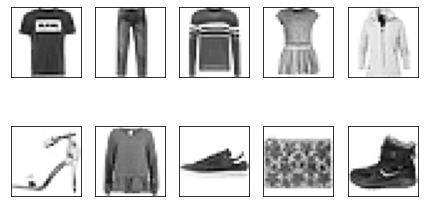

In [12]:
fig, ax  = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Step 4: Saving the images as PNG files

Creating PNG images from numpy arrays

In [13]:
from PIL import Image

In [14]:
if not os.path.exists('png-files'):
    os.mkdir('png-files')

for idx, row in enumerate(X_train):
    file_name = f"{idx}.png"
    file_path = os.path.join('png-files', file_name)
    im = Image.fromarray(row.reshape(28, 28))
    im.save(file_path)

In [15]:
for idx, row in enumerate(X_test):
    file_name = f"{X_train.shape[0] + idx}.png"
    file_path = os.path.join('png-files', file_name)
    im = Image.fromarray(row.reshape(28, 28))
    im.save(file_path)

In [16]:
len(os.listdir('png-files'))

70000

### Creating CSV files with class labels

In [17]:
import pandas as pd

In [18]:
df_train = pd.DataFrame(y_train, columns=['class_label'])
df_train['image_name'] = [f"{idx}.png" for idx in range(y_train.shape[0])]
df_train.head()

,class_label,image_name
0,9,0.png
1,0,1.png
2,0,2.png
3,3,3.png
4,0,4.png


In [20]:
df_shuffled = df_train.sample(n=df_train.shape[0], random_state=123)

In [21]:
df_trainset = df_shuffled.iloc[:55000]
df_validset = df_shuffled.iloc[55000:]

In [23]:
df_testset = pd.DataFrame(y_test, columns=['class_label'])
df_testset['image_name'] = [f"{X_train.shape[0]+idx}.png" for idx in range(y_test.shape[0])]
df_testset.head() 

,class_label,image_name
0,9,60000.png
1,2,60001.png
2,1,60002.png
3,1,60003.png
4,6,60004.png


In [24]:
df_trainset.to_csv('train.csv', index=None)
df_validset.to_csv('valid.csv', index=None)
df_testset.to_csv('test.csv', index=None)

### Homework

### Imports

In [25]:


import torch
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [30]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
class FashionMNISTDataset(Dataset):
    """Custom Dataset for loading FashionMNIST images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['image_name'].values
        self.y = df['class_label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [60]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

custom_train_transform = transforms.Compose([  
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])



In [61]:
####################################################################
# THIS CELL CAN BE MODIFIED BUT THERE SHOULD NOT BE ANY RANDOMNESS
####################################################################

custom_test_transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5,), std=(0.5,))
])



In [62]:
### Can be modified

BATCH_SIZE = 64

In [63]:
train_dataset = FashionMNISTDataset(csv_path='train.csv',
                                    img_dir='png-files/',
                                    transform=custom_train_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          drop_last=True,
                          num_workers=4)


valid_dataset = FashionMNISTDataset(csv_path='valid.csv',
                                    img_dir='png-files/',
                                    transform=custom_test_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)


test_dataset = FashionMNISTDataset(csv_path='test.csv',
                                   img_dir='png-files/',
                                   transform=custom_test_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)



In [64]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 64
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 64
break minibatch for-loop


In [69]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################


class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_hidden_3, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
        
        ### ADD ADDITIONAL LAYERS BELOW IF YOU LIKE
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_hidden_2)
        self.linear_3 = torch.nn.Linear(num_hidden_2, num_hidden_3)
        self.linear_out = torch.nn.Linear(num_hidden_3, num_classes)
        
    def forward(self, x):
        
        ### MAKE SURE YOU CONNECT THE LAYERS PROPERLY IF YOU CHANGED
        ### ANYTHNG IN THE __init__ METHOD ABOVE       
        out = self.linear_1(x)

        out = torch.relu(out)
        out = self.linear_2(out)
        out = torch.relu(out)
        out = self.linear_3(out)
        out = torch.relu(out)
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
#################################
### Model Initialization
#################################


# the random seed makes sure that the random weight initialization
# in the model is always the same.
# In practice, some weights don't work well, and we may also want
# to try different random seeds. In this homework, this is not
# necessary.
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### IF YOU CHANGED THE ARCHITECTURE ABOVE, MAKE SURE YOU 
### ACCOUNT FOR IT VIA THE PARAMETERS BELOW. I.e., if you
### added a second hidden layer, you may want to add a
### hidden_2 parameter here. Also you may want to play
### with the number of hidden units.
model = MLP(num_features=28*28,
            num_hidden_1=256,
            num_hidden_2=128,
            num_hidden_3 = 64,
            num_classes=10)

model = model.to(DEVICE)

In [70]:
############################################################
# THIS CELL CAN BE MODIFIED
############################################################

### For this homework, do not change the optimizer. However, you
### likely want to experiment with the learning rate!
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
############################################################

In [78]:
## this cell can be modified
NUM_EPOCHS = 30

In [79]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/030 | Batch 000/859 | Cost: 0.2793
Epoch: 001/030 | Batch 020/859 | Cost: 0.2043
Epoch: 001/030 | Batch 040/859 | Cost: 0.1906
Epoch: 001/030 | Batch 060/859 | Cost: 0.1010
Epoch: 001/030 | Batch 080/859 | Cost: 0.2830
Epoch: 001/030 | Batch 100/859 | Cost: 0.2904
Epoch: 001/030 | Batch 120/859 | Cost: 0.1785
Epoch: 001/030 | Batch 140/859 | Cost: 0.1796
Epoch: 001/030 | Batch 160/859 | Cost: 0.2487
Epoch: 001/030 | Batch 180/859 | Cost: 0.1306
Epoch: 001/030 | Batch 200/859 | Cost: 0.1628
Epoch: 001/030 | Batch 220/859 | Cost: 0.2197
Epoch: 001/030 | Batch 240/859 | Cost: 0.2261
Epoch: 001/030 | Batch 260/859 | Cost: 0.1047
Epoch: 001/030 | Batch 280/859 | Cost: 0.2618
Epoch: 001/030 | Batch 300/859 | Cost: 0.2796
Epoch: 001/030 | Batch 320/859 | Cost: 0.1675
Epoch: 001/030 | Batch 340/859 | Cost: 0.2536
Epoch: 001/030 | Batch 360/859 | Cost: 0.2984
Epoch: 001/030 | Batch 380/859 | Cost: 0.1967
Epoch: 001/030 | Batch 400/859 | Cost: 0.2845
Epoch: 001/030 | Batch 420/859 | C

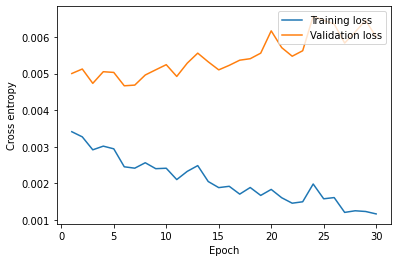

In [80]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

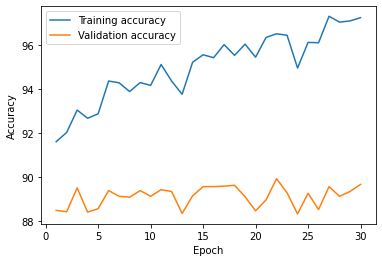

In [81]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.show()

In [82]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 88.91%
